In [34]:
import pandas as pd
import numpy as np 
import seaborn as sns
from sklearn.metrics import accuracy_score

# Reconocimiento de dígitos con KNN



Definir los path al ejecutable de python 3.6 y sus librerías,
de acuerdo al virtual env que estén corriendo.

In [23]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/gianluca/Documents/Metodos Numericos/tp2/bin/python (found version "3.8.2") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.8.so
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/gianluca/Documents/Metodos Numericos/github_g

In [24]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum


/home/gianluca/Documents/Metodos Numericos/github_grupal/metodos-num/tp2/notebooks
Python 3.8.2


## Explorando los datos

In [25]:
%load_ext autoreload
%autoreload 2

df_train = pd.read_csv("../data/train.csv")

Es un csv, con columnas por cada pixel

In [4]:
df_train[:10]

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Reducir el dataset

Ya que el dataset es grande, me quedo con una porción de éste

**<font color=red>ESTO ES SOLO PARA HACER PRUEBAS. CUANDO REPORTEN LOS RESULTADOS, USAR DATASET COMPLETO</font>**

In [26]:
df_train = df_train[:5000]

En el primer caracter está el dígito a reconocer. Llamamos a esto `y_train`

In [27]:
# Uso values para mandar todo a arrays de numpy
X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)

X.shape, y.shape

((5000, 784), (5000, 1))

Convierto el resto a matrices de 28 x 28

A ver cómo se ven...

Supuestamente es un 0


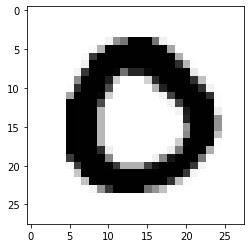

In [28]:
import matplotlib.pyplot as plt

num = 4

print(f"Supuestamente es un {int(y[num])}")

img = X[num].reshape(28, 28)
plt.imshow(img, cmap="Greys")


### Balance de clases

¿Tenemos la misma cantidad de cada número?

In [8]:
df_train["label"].value_counts(normalize=True)

1    0.1116
2    0.1090
6    0.1032
7    0.1012
0    0.0988
3    0.0960
9    0.0956
8    0.0954
4    0.0954
5    0.0938
Name: label, dtype: float64

No: tenemos más 1 que 5, pero tampoco está tan desbalanceado

### Conjunto de development

In [29]:
limit = int(0.8 * X.shape[0]) 

X_train, y_train = X[:limit], y[:limit]
X_val, y_val = X[limit:], y[limit:]

assert len(X_train) == len(y_train)
assert len(X_val) == len(y_val)

print(f"Ahora tengo {len(X_train)} instancias de entrenamiento y {len(X_val)} de validación")


Ahora tengo 4000 instancias de entrenamiento y 1000 de validación


In [30]:
def pca(alpha, train,validacion):
    pca= metnum.PCA(alpha)
    pca.fit(train)
    train_pca = pca.transform(train)
    val_pca = pca.transform(validacion)
    return train_pca, val_pca

In [31]:
def numpy_to_csv(x,val,alpha,nset):
    df_x = pd.DataFrame(data=x)
    df_x.to_csv(f"transformaciones/{nset}_{alpha}_train.csv",index=False)
    df_val = pd.DataFrame(data=val)
    df_val.to_csv(f"transformaciones/{nset}_{alpha}_val.csv",index=False)

In [41]:
alpha_max = 50
k_max = 30
salto_alpha = 5
salto_k = 5

alphas = [1] + [i*salto_alpha for i in range(1, int(alpha_max/salto_alpha) + 1)]
Ks = [1] + [i*salto_k for i in range(1,int(k_max/salto_k) + 1)]

In [42]:
alphas, Ks

([1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50], [1, 5, 10, 15, 20, 25, 30])

In [43]:
from timeit import default_timer as timer
start = timer()


X_pca_max, X_val_pca_max = pca(alpha_max,X_train,X_val)
#numpy_to_csv(X_pca_max,X_val_pca_max,alpha,5000)

col_alphas = []
col_k = []
precisiones = []

for alpha in alphas :
    
    X_pca, X_val_pca = X_pca_max[0:, 0:alpha], X_val_pca_max[0:, 0:alpha]
    
    for k in Ks :
        
        clf = metnum.KNNClassifier(k)
        clf.fit(X_pca, y_train)
        y_pred = clf.predict(X_val_pca)
        acc = accuracy_score(y_val, y_pred)
        
        #para armar dsp el dataframe
        precisiones.append(acc)
        col_alphas.append(alpha)
        col_k.append(k)

        
        
end = timer()
print(end - start)

18.399812768999254


In [45]:
dat = pd.DataFrame({"Alpha":col_alphas,"K":col_k,"Precisión": precisiones})
dat = dat.pivot("Alpha","K","Precisión")
#dat.to_csv("nombre.csv",index = True,header = True)
dat

K,1,5,10,15,20,25,30
Alpha,,,,,,,
1,0.229,0.249,0.284,0.287,0.304,0.305,0.299
5,0.661,0.715,0.720,0.728,0.725,0.733,0.729
10,0.883,0.898,0.886,0.880,0.876,0.871,0.871
15,0.923,0.930,0.924,0.922,0.913,0.913,0.905
20,0.938,0.944,0.941,0.934,0.918,0.923,0.920
25,0.931,0.948,0.944,0.933,0.924,0.925,0.917
30,0.935,0.944,0.942,0.934,0.931,0.924,0.924
35,0.935,0.944,0.942,0.933,0.935,0.926,0.921
40,0.934,0.947,0.939,0.934,0.927,0.923,0.921


In [49]:
indmax = precisiones.index(max(precisiones))

print(f" Mejor (alpha, k): ({col_alphas[indmax]}, {col_k[indmax]})")

 Mejor (alpha, k): (25, 5)


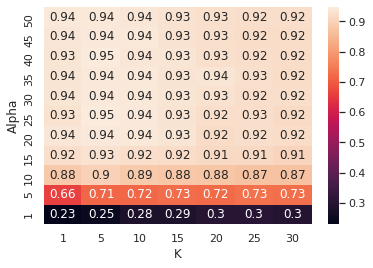

In [53]:
import seaborn as sns; sns.set()


hmap = sns.heatmap(dat,annot = True)#,cmap = "YlGnBu") # colores de mapa claros
hmap.invert_yaxis()

In [54]:
def train(k,alpha,X,y,X_val,y_val):
    X_pca, X_val_pca = pca(alpha,X,X_val)

    clf = metnum.KNNClassifier(k)
    clf.fit(X_pca, y)
    y_pred = clf.predict(X_val_pca)

    acc = accuracy_score(y_val, y_pred)
    print("Accuracy: {}".format(acc))
